In [78]:
from utils import *
from environnement import Environnement
from policies import Policy,RandomPolicy,SmarterRandomPolicy
from tester import Tester
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bnoyt/anaconda3/lib/python3.7/site-packages/tensorflo

In [79]:
class EGreedyPolicy(Policy):
    """
    Example de policy qui fait un epsilon greedy (mais qui marche pas trop trop)
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.eps = self.params["eps"]
        self.__name__ = f"EGreedyPolicy_{params['price']}"
        

            
        
    def get_action(self,context):
        
        df = self.get_history() # La méthode pour récupérer l'historique
        
        df = df[df.user_id == context['user_id']]
        
        if self.rng.uniform() < self.eps or len(df) < 10:
        
            a = [len(d) for d in context["bikes_availability"]]

            chosen_index = self.rng.randint(0,len(a))  

            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]

        
        
        else:
            bikes_ids = pd.DataFrame({
                'bike_id':context["bikes_available"]
            })
            
            
            df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=False)
            
            chosen_index = context["bikes_available"].index(df.bike_id.values[0])
            
            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]

            
            else :
                
                #bikes_ids a une seule colonne 'bike_id' qui contient les id des bikes
                bikes_ids = pd.DataFrame({
                        'bike_id':context["bikes_available"]
                    })

                df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)

                #crée la colonne contenant le Nt(a) du dénominateur dans ucb
                df2 = self.get_history()[self.get_history().user_id == context['user_id']].groupby('bike_id').accepted.sum().reset_index()
                df2.columns=['bike_id','sum_accepted']

                df = df.merge(df2,on='bike_id')

                #on suppose c=1
                df['arg_ucb']=df.apply(lambda x : (x['accepted'] + np.sqrt(context['day']/x['sum_accepted'])),axis=1)

                df=df.reset_index().sort_values(by=['arg_ucb'],ascending=False)

                chosen_index = context["bikes_available"].index(df.bike_id.values[0])

                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]

In [3]:
class UCBPolicy(Policy):
    """
    Exemple de UCB policy
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.__name__ = f"UCBPolicy_{params['price']}"
        
        
        
    def get_action(self,context):
        
        df = self.get_history() 
        u = df.copy()
        
        #on veut s'assurer que les Nt(a) ne valent pas 0 donc on doit attribuer chaque vélo au moins une fois
        if df.shape[0]<self.params["n_bikes"]:
            return [context["bikes_available"][df.shape[0]]],[context['bikes_availability'][df.shape[0]]],[self.params["price"]]
        
        else :

            df = df[df.user_id == context['user_id']]

            if len(df) < 10:
                a = [len(d) for d in context["bikes_availability"]]
                chosen_index = self.rng.randint(0,len(a))  
                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
                return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]

            
            else :
                
                #bikes_ids a une seule colonne 'bike_id' qui contient les id des bikes
                bikes_ids = pd.DataFrame({
                        'bike_id':context["bikes_available"]
                    })

                df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)

                #crée la colonne contenant le Nt(a) du dénominateur dans ucb
                
                
                df2 = u[u.user_id == context['user_id']].groupby('bike_id').accepted.sum().reset_index()
                df2.columns=['bike_id','sum_accepted']

                df = df.merge(df2,on='bike_id')

                #on suppose c=1
                df['arg_ucb']=df.apply(lambda x : (x['accepted'] + np.sqrt(context['day']/x['sum_accepted'])),axis=1)
                
                
                correction =    [    np.exp(-abs(len(days) - len(context['days_wanted']))) for days in context['bikes_availability']]
                correction = pd.DataFrame({"correction":correction,"bike_id":context["bikes_available"]})
                
                df = df.merge(correction,on="bike_id")
                
                df["arg_ucb"] = df["arg_ucb"]*df.correction

                df=df.reset_index().sort_values(by=['arg_ucb'],ascending=False)

                chosen_index = context["bikes_available"].index(df.bike_id.values[0])

                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
                return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]


In [4]:
from keras.layers import Embedding, Flatten, Dense, Dropout,Input
from keras.layers import Dot
from keras.models import Model


class DeepPolicy(Policy):
    """
    Example de policy qui fait un epsilon greedy (mais qui marche pas trop trop)
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.eps = self.params["eps"]
        self.__name__ = f"DeepPolicy_{params['price']}"
        
        
    def init(self):
        self.rng = np.random.RandomState(self.seed)
        self.history = []
        
        
        user_inputs = Input(shape=(1,))
        bike_inputs = Input(shape=(1,))
        
        user_embedding = Embedding(output_dim=self.params["embedding_size"],
                                        input_dim=self.params["n_users"],
                                        input_length=1,
                                        name='user_embedding')
        bike_embedding = Embedding(output_dim=self.params["embedding_size"],
                                        input_dim=self.params["n_bikes"],
                                        input_length=1,
                                        name='bike_embedding')
        
        user_vecs = Flatten()(user_embedding(user_inputs))
        bike_vecs = Flatten()(bike_embedding(bike_inputs))
        
        final_layer = Dot(axes=1)([user_vecs, bike_vecs])
        
        
        self.model = Model(inputs=[user_inputs,bike_inputs],outputs=[final_layer])
        
        
        self.model.compile(optimizer="adam", loss='mae') 
        

            
        
    def get_action(self,context):
        
        df = self.get_history() # La méthode pour récupérer l'historique
        
        df = df[df.user_id == context['user_id']]
        
        if len(df) < 100:
        
            a = [len(d) for d in context["bikes_availability"]]


            chosen_index = self.rng.randint(0,len(a))  

            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]
        
        
        else:
            
            X1,X2 =   df[["user_id","bike_id"]].values[:,0],df[["user_id","bike_id"]].values[:,1]
            y = df["accepted"].values
            
            
            
            
            self.model.fit([X1,X2],y,verbose=0)
            
            
            X1,X2 = [context["user_id"] for v in context["bikes_available"]], [v for v in context["bikes_available"]]
            
            
            ratings = self.model.predict([X1,X2])
            
            correction =    [    np.exp(-abs(len(days) - len(context['days_wanted']))) for days in context['bikes_availability']]
            
        
            ratings = [x*y for (x,y) in zip(ratings,correction)]
            
            chosen_index = np.argmax(ratings)
            
            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            return [context["bikes_available"][chosen_index]],[context['days_wanted']],[self.params["price"]]
            
            
            
            
            
            
         

In [83]:
params = {
    'n_steps':2000,
    "n_rep":5
}
env_params = {
    'experiment_length':2000, # Beaucoup de jours
    "n_users":2, #peu d'utilisateur
    "n_clusters":2, # peu de vélos
    'dim':10,
    "n_bikes_per_user":1, # Un seul vélo proposé à chaque fois
    "users_per_day":1,
    'bike_overlapping':True
}
env = Environnement(env_params,4)

In [84]:
tester2 = Tester([
    UCBPolicy({"list_length":1,"price":10,"n_bikes":2,"eps":0.5},3),
],env,params)

In [85]:
tester2.run()







  0%|          | 0/5 [00:00<?, ?it/s]

Testing policy |UCBPolicy_10|








 20%|██        | 1/5 [00:18<01:15, 18.95s/it]





 40%|████      | 2/5 [00:37<00:56, 18.89s/it]/home/coralie/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in double_scalars






 60%|██████    | 3/5 [00:56<00:37, 18.77s/it]





 80%|████████  | 4/5 [01:14<00:18, 18.71s/it]





100%|██████████| 5/5 [01:32<00:00, 18.51s/it]







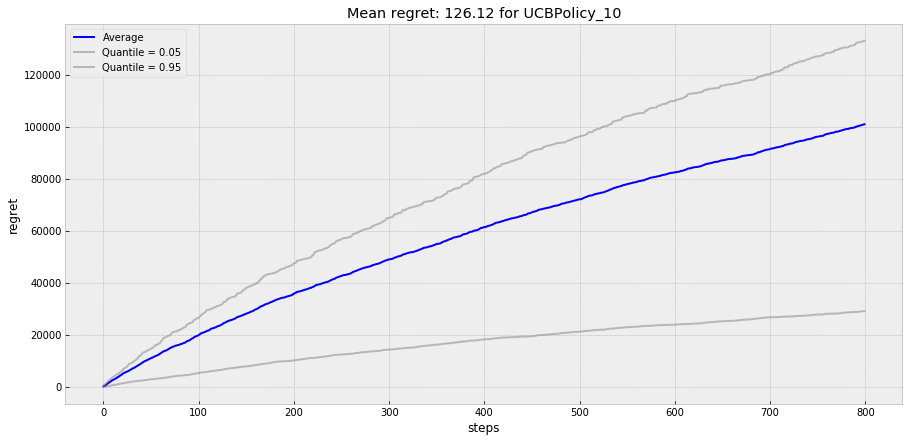

In [86]:
tester2.plotAllPoliciesQuantiles()

In [8]:
tester = Tester([
    UCBPolicy({"list_length":1,"price":500,"n_bikes":2,"eps":0.5},3),
    DeepPolicy({"list_length":1,"price":500,"n_bikes":2,"eps":0.5,"n_users":2,"embedding_size":10},3),
    EGreedyPolicy({"list_length":1,"price":500,"n_bikes":2,"eps":0.5},3),
    RandomPolicy({"list_length":1,"price":500},3),
    SmarterRandomPolicy({"list_length":1,"price":500},3),
    
    
],env,params)

In [7]:
tester.run()

  1%|          | 17/2000 [00:00<00:12, 161.12it/s]

Testing policy |UCBPolicy_500| rep 0/5


  1%|          | 19/2000 [00:00<00:10, 183.31it/s]

Testing policy |UCBPolicy_500| rep 1/5


  1%|          | 18/2000 [00:00<00:11, 166.79it/s]

Testing policy |UCBPolicy_500| rep 2/5


  1%|          | 18/2000 [00:00<00:11, 172.97it/s]

Testing policy |UCBPolicy_500| rep 3/5


  1%|          | 19/2000 [00:00<00:10, 181.81it/s]

Testing policy |UCBPolicy_500| rep 4/5


  1%|          | 17/2000 [00:00<00:11, 168.01it/s]

Testing policy |DeepPolicy_500| rep 0/5


 10%|▉         | 196/2000 [00:01<00:11, 152.51it/s]

  1%|          | 19/2000 [00:00<00:10, 185.74it/s]

Testing policy |DeepPolicy_500| rep 1/5


  1%|          | 18/2000 [00:00<00:11, 166.71it/s]

Testing policy |DeepPolicy_500| rep 2/5


  1%|          | 19/2000 [00:00<00:10, 185.45it/s]

Testing policy |DeepPolicy_500| rep 3/5


  1%|          | 19/2000 [00:00<00:10, 185.26it/s]

Testing policy |DeepPolicy_500| rep 4/5


  1%|          | 18/2000 [00:00<00:11, 175.22it/s]

Testing policy |EGreedyPolicy_500| rep 0/5


  1%|          | 18/2000 [00:00<00:11, 172.69it/s]

Testing policy |EGreedyPolicy_500| rep 1/5


  1%|          | 18/2000 [00:00<00:11, 177.65it/s]

Testing policy |EGreedyPolicy_500| rep 2/5


  1%|          | 19/2000 [00:00<00:10, 181.96it/s]

Testing policy |EGreedyPolicy_500| rep 3/5


  1%|          | 18/2000 [00:00<00:11, 177.49it/s]

Testing policy |EGreedyPolicy_500| rep 4/5


  1%|          | 22/2000 [00:00<00:09, 214.76it/s]

Testing policy |RandomPolicy_500| rep 0/5


  1%|          | 22/2000 [00:00<00:09, 210.24it/s]

Testing policy |RandomPolicy_500| rep 1/5


  1%|          | 22/2000 [00:00<00:09, 215.89it/s]

Testing policy |RandomPolicy_500| rep 2/5


  1%|          | 21/2000 [00:00<00:09, 205.30it/s]

Testing policy |RandomPolicy_500| rep 3/5


  1%|          | 23/2000 [00:00<00:09, 219.53it/s]

Testing policy |RandomPolicy_500| rep 4/5


  1%|          | 22/2000 [00:00<00:09, 217.71it/s]

Testing policy |SmarterRandomPolicy_500| rep 0/5


  1%|          | 22/2000 [00:00<00:09, 210.14it/s]

Testing policy |SmarterRandomPolicy_500| rep 1/5


  1%|          | 22/2000 [00:00<00:09, 219.18it/s]

Testing policy |SmarterRandomPolicy_500| rep 2/5


  1%|          | 23/2000 [00:00<00:08, 222.80it/s]

Testing policy |SmarterRandomPolicy_500| rep 3/5


  1%|          | 22/2000 [00:00<00:09, 219.20it/s]

Testing policy |SmarterRandomPolicy_500| rep 4/5


100%|██████████| 2000/2000 [00:09<00:00, 200.49it/s]


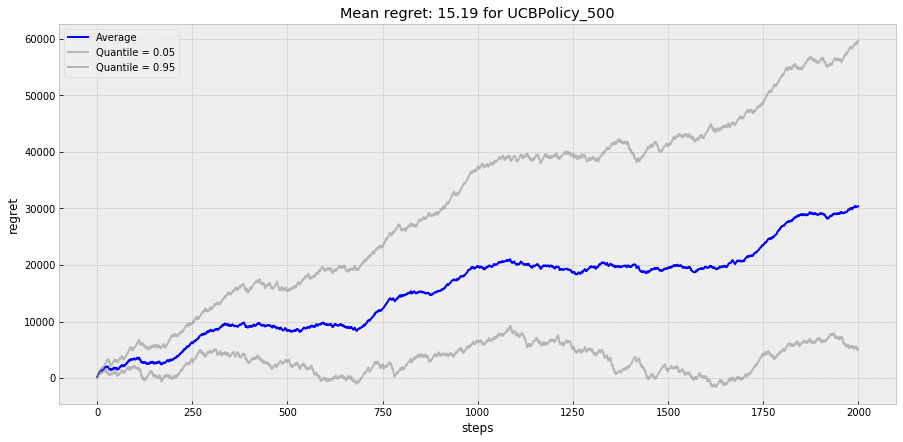

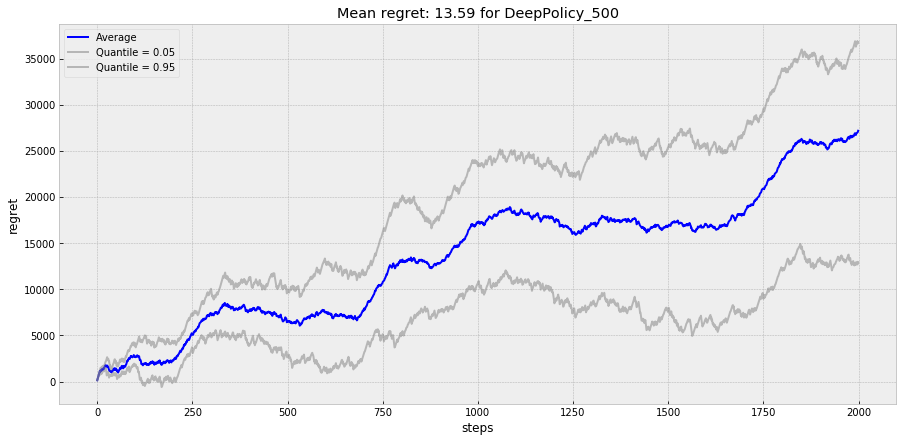

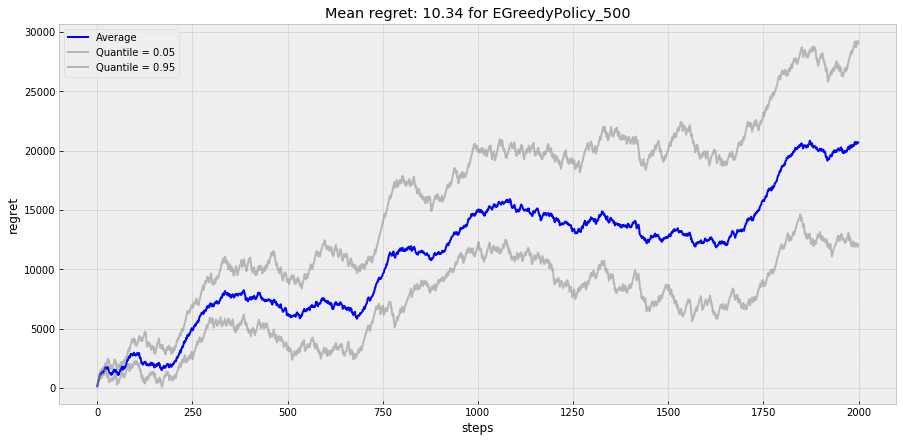

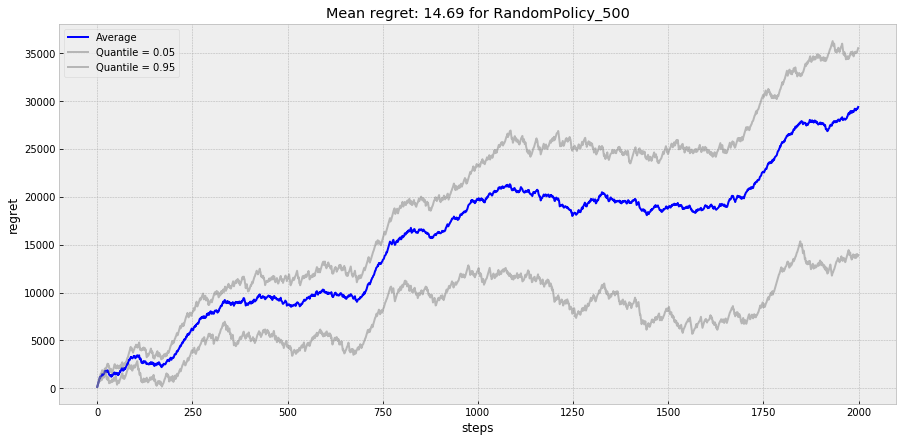

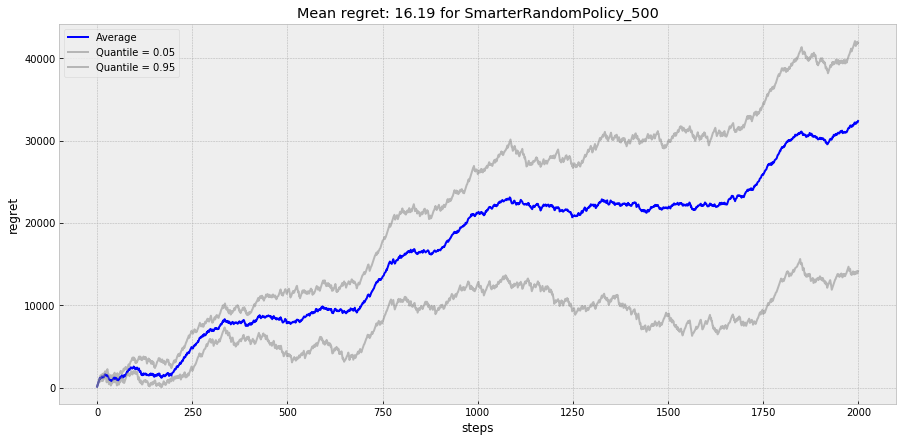

In [8]:
tester.plotAllPoliciesQuantiles()

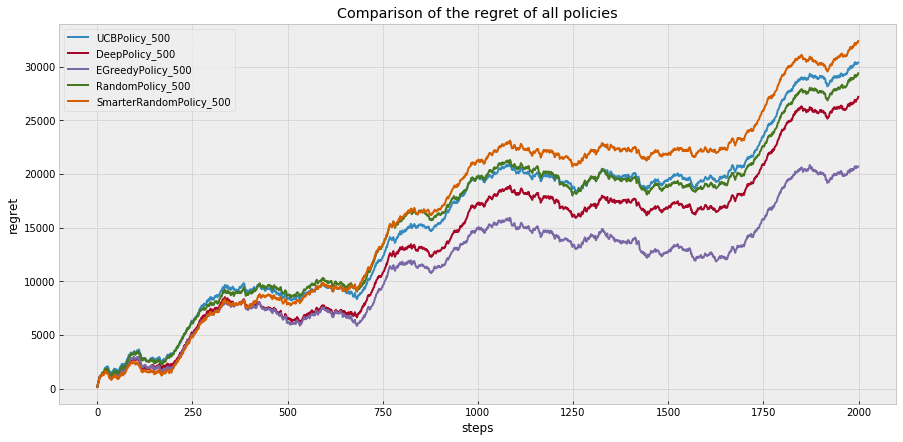

In [9]:
tester.plotAllPoliciesCompared()

In [10]:
tmps = []
for i in tester.history:
    for tmp in tester.history[i]:
        tmp['policy'] = i
        tmps.append(tmp.copy())
    
df = pd.concat(tmps)

In [11]:
df.bike_proposed = df.bike_proposed.apply(lambda x: x[0])

In [12]:
def accuracy(x,y):
    return (x == y).astype(int).mean()

In [13]:
df.groupby("policy").apply(lambda x: accuracy(x.bike_proposed,x.best_bike))

policy
DeepPolicy_500             0.5042
EGreedyPolicy_500          0.6881
RandomPolicy_500           0.4879
SmarterRandomPolicy_500    0.4543
UCBPolicy_500              0.5555
dtype: float64

In [14]:
df = df.reset_index()

In [15]:
df.columns = ['step', 'user_id', 'days_wanted', 'bike_proposed', 'price_proposed',
       'days_proposed', 'answer', 'reward', 'best_reward', 'probas',
       'best_bike', 'policy']

In [16]:
df["step_bucket"] = df.step // 500

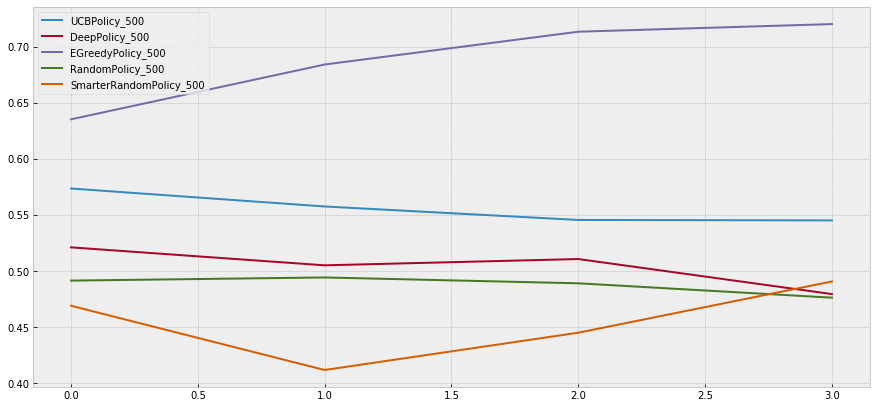

In [17]:
plt.figure(figsize=(15,7))

for i in df.policy.unique():
    plt.plot(df[df.policy == i].groupby("step_bucket").apply(lambda x: accuracy(x.bike_proposed,x.best_bike)),label=i)
    
plt.legend()